# Import libraries

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import time

# for audio
from IPython.display import Audio
import librosa

# for preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# for modeling
import tensorflow as tf
from sklearn.metrics import classification_report

# For visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# For drive access
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# define classes to extract features from audio files

In [ ]:
class Framed:

  def __init__(self,
               dataframe,
               is_train=True,
               sr=16000,
               window_size_s=8.0,
               hop_size_s=4.0
               ):
    """
    Instantiate the Framed class, create train and val dfs
    The extract_framed() method is automatically called to extract the framed audios and add to the train and val dfs

    Alternative, the extract_framed() method could be called separately if needed by passing a dataframe to it as parameter

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information
      sr (int): Sample rate of the audio files. Default = 16000
      window_size_s (float): Window size in seconds for framing the audio. Default = 8.0
      hop_size_s (float): Hop size in seconds for framing the audio. Default = 4.0
    """

    self.sr = sr
    self.frame_length = int(window_size_s * sr)
    self.frame_step = int(hop_size_s * sr)
    self.dataframe = dataframe
    self.is_train = is_train

    self.extract_framed(self.dataframe)

  def extract_framed(self, dataframe):
    """
    Load audio files from the given DataFrame, extract framed audios, and add the framed audios to the given DataFrame

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information
    """

    # load audios
    audios = []
    if self.is_train:
      filepath = '/content/drive/MyDrive/207/207-Project/data/train/librosa_loaded/'
    else:
      filepath = '/content/drive/MyDrive/207/207-Project/data/test/librosa_loaded/'
    for filename in dataframe['filename_npy']:
      audio = np.load(filepath + filename)
      audios.append(audio)
    assert len(audios) == len(dataframe)

    # extract framed audios
    framed = []
    for audio in audios:
      framed_audio = tf.signal.frame(audio, self.frame_length, self.frame_step, pad_end=False)
      framed.append(framed_audio)
    assert len(framed) == len(audios)
    del audios

    # add framed audios to df
    dataframe['framed'] = framed
    del framed

In [ ]:
class Extraction:

  def __init__(self,
               train_df,
               test_df,
               sr=16000,
               n_mfccs=20, #20 is the default n_mfccs from librosa
               n_mels=20, #reduced from 128 default from librosa to 20
               n_chroma=12, #12 is the default n_chroma from librosa
               features=['mfcc'],
               normalize=True,
               avgpool=True
               ):
    """
    Instantiate the Extraction class and extract the labels and features from train and val DataFrames
    The extract_features() method is automatically called to extract the labels and features from the given DataFrame

    Parameters:
      train_df (pd.DataFrame): DataFrame containing training data
      test_df (pd.DataFrame): DataFrame containing validation data
      sr (int): Sample rate of the audio files. Default = 16000
      duration_s (float): Length of framed audios in seconds
      features (list): List features to extract. Default = ['mfcc']
        acceptable features: 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating'
      normalize (bool): Whether to normalize the features
      maxpool (bool): Whether to maxpool the features

    """
    self.sr = sr
    self.n_mfccs = n_mfccs
    self.n_mels = n_mels
    self.n_chroma = n_chroma

    # confirm features have been specified
    assert len(features) != 0, "Must Specify At Least One Feature In The Form Of A List"
    self.features = features

    # confirm features are valid
    self.accepted_feature = ['mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating']
    for each in self.features:
      assert each in self.accepted_feature, f"{each} is not an accepted feature, only 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating' are acceptable features"

    # extract train and val labels and features
    self.train_y, self.train_features = self.extract_features(train_df)
    self.test_y, self.test_features = self.extract_features(test_df)

    # normalize and/or maxpool the features
    if normalize is True:
      self.train_features, self.test_features = self.normalize_features(self.train_features, self.test_features)
    if avgpool is True:
      self.train_features, self.test_features = self.avgpool_features(self.train_features, self.test_features)
    else:
      self.train_features = self.train_features
      self.test_features = self.test_features


  # each of the extract_feature() function is callable by the extract_features() function based on the features instantiated
  # each of the features are extracted from librosa and transposed to represent (time_shape, n_features)
  def extract_mfcc(self, each):
    return np.transpose(librosa.feature.mfcc(y=np.array(each), sr=self.sr, n_mfcc=self.n_mfccs))

  def extract_chroma(self, each):
    return np.transpose(librosa.feature.chroma_cens(y=np.array(each), sr=self.sr, n_chroma=self.n_chroma))

  def extract_rms(self, each):
    return np.transpose(librosa.feature.rms(y=np.array(each)))

  def extract_spectral_centroid(self, each):
    return np.transpose(librosa.feature.spectral_centroid(y=np.array(each), sr=self.sr))

  def extract_melspectrogram(self, each):
    mel = librosa.feature.melspectrogram(y=np.array(each), sr=self.sr, n_mels=self.n_mels)
    return np.transpose(librosa.power_to_db(mel))


  # normalization function which normalizes any given feature of train and val
  def normalization(self, train_X, test_X, n_time, n_features):
    train_X_reshape = train_X.reshape(-1, n_time * n_features)
    test_X_reshape = test_X.reshape(-1, n_time * n_features)

    scaler = MinMaxScaler((0,1)).fit(train_X_reshape)

    train_X_scaled = scaler.transform(train_X_reshape)
    test_X_scaled = scaler.transform(test_X_reshape)

    train_X = train_X_scaled.reshape(-1, n_time, n_features)
    test_X = test_X_scaled.reshape(-1, n_time, n_features)

    return train_X, test_X


  # avgerage pooling function which average pool any given feature of train and val
  def avgpooling(self, train_X, test_X, n_time, n_features):
    input = tf.keras.layers.Input(shape=(n_time, n_features))
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
    pooled = global_avg_pooling(input)
    pooling_model = tf.keras.models.Model(inputs=input, outputs=pooled)

    train_X = pooling_model.predict(train_X)
    test_X = pooling_model.predict(test_X)

    return train_X, test_X


  # normalize the features if needed
  # 'continent', 'rating' do not need to be normalized
  def normalize_features(self, train_features_dict, test_features_dict):
    start_time = time.time()
    display('features normalization started ---------->')

    # normalize mfcc
    if 'mfcc' in train_features_dict.keys():
      train_feature = train_features_dict['mfcc']
      test_feature = test_features_dict['mfcc']
      train_features_dict['mfcc'], test_features_dict['mfcc'] = self.normalization(train_feature, test_feature, n_time=train_feature.shape[1], n_features=self.n_mfccs)
      display('mfcc normalized')

    # normalize chroma
    if 'chroma' in train_features_dict.keys():
      train_feature = train_features_dict['chroma']
      test_feature = test_features_dict['chroma']
      train_features_dict['chroma'], test_features_dict['chroma'] = self.normalization(train_feature, test_feature, n_time=train_feature.shape[1], n_features=self.n_chroma)
      display('chroma normalized')

    # normalize rms
    if 'rms' in train_features_dict.keys():
      train_feature = train_features_dict['rms']
      test_feature = test_features_dict['rms']
      train_features_dict['rms'], test_features_dict['rms'] = self.normalization(train_feature, test_feature, n_time=train_feature.shape[1], n_features=1)
      display('rms normalized')

    # normalize spectral_centroid
    if 'spectral_centroid' in train_features_dict.keys():
      train_feature = train_features_dict['spectral_centroid']
      test_feature = test_features_dict['spectral_centroid']
      train_features_dict['spectral_centroid'], test_features_dict['spectral_centroid'] = self.normalization(train_feature, test_feature, n_time=train_feature.shape[1], n_features=1)
      display('spectral_centroid normalized')

    # normalize melspectrogram
    if 'melspectrogram' in train_features_dict.keys():
      train_feature = train_features_dict['melspectrogram']
      test_feature = test_features_dict['melspectrogram']
      train_features_dict['melspectrogram'], test_features_dict['melspectrogram'] = self.normalization(train_feature, test_feature, n_time=train_feature.shape[1], n_features=self.n_mels)
      display('melspectrogram normalized')

    end_time = time.time()
    display(f'features normalization took {(end_time - start_time)/60:.1f} mins')

    return train_features_dict, test_features_dict


  # average pool the features if needed
  # 'continent', 'rating' do not need to be pooled
  def avgpool_features(self, train_features_dict, test_features_dict):
    start_time = time.time()
    display('features average pooling started ---------->')

    # average pool mfcc
    if 'mfcc' in train_features_dict.keys():
      train_feature = train_features_dict['mfcc']
      test_feature = test_features_dict['mfcc']
      train_features_dict['mfcc'], test_features_dict['mfcc'] = self.avgpooling(train_feature, test_feature, n_time=train_feature.shape[1], n_features=self.n_mfccs)
      display('mfcc avgpooled')

    # average pool chroma
    if 'chroma' in train_features_dict.keys():
      train_feature = train_features_dict['chroma']
      test_feature = test_features_dict['chroma']
      train_features_dict['chroma'], test_features_dict['chroma'] = self.avgpooling(train_feature, test_feature, n_time=train_feature.shape[1], n_features=self.n_chroma)
      display('chroma avgpooled')

    # average pool rms
    if 'rms' in train_features_dict.keys():
      train_feature = train_features_dict['rms']
      test_feature = test_features_dict['rms']
      train_features_dict['rms'], test_features_dict['rms'] = self.avgpooling(train_feature, test_feature, n_time=train_feature.shape[1], n_features=1)
      display('rms avgpooled')

    # average pool spectral_centroid
    if 'spectral_centroid' in train_features_dict.keys():
      train_feature = train_features_dict['spectral_centroid']
      test_feature = test_features_dict['spectral_centroid']
      train_features_dict['spectral_centroid'], test_features_dict['spectral_centroid'] = self.avgpooling(train_feature, test_feature, n_time=train_feature.shape[1], n_features=1)
      display('spectral_centroid avgpooled')

    # average pool melspectrogram
    if 'melspectrogram' in train_features_dict.keys():
      train_feature = train_features_dict['melspectrogram']
      test_feature = test_features_dict['melspectrogram']
      train_features_dict['melspectrogram'], test_features_dict['melspectrogram'] = self.avgpooling(train_feature, test_feature, n_time=train_feature.shape[1], n_features=self.n_mels)
      display('melspectrogram avgpooled')

    end_time = time.time()
    display(f'features average pooling took {(end_time - start_time)/60:.1f} mins')

    return train_features_dict, test_features_dict


  def extract_features(self, dataframe):
    """
    Extract the label & features from the dataframes

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information

    Returns:
      tuple: Tuple containing labels and a dictionary of extracted features
    """
    start_time = time.time()
    display(f'feature extraction started ---------->')

    y = []
    features_dict = {item: [] for item in self.features}

    for _, row in dataframe.iterrows():
      label = row['primary_label']
      framed = row['framed']

      for each in framed:
        y.append(label)

        if 'continent' in self.features:
          features_dict['continent'].append(row['continent'])
        if 'rating' in self.features:
          features_dict['rating'].append(row['rating'])

        for feature in self.features:
          extract = f"extract_{feature}"
          if hasattr(self, extract) and callable(func := getattr(self, extract)):
            features_dict[feature].append(func(each))

    # cast lists to np arrays
    for each in features_dict.keys():
      features_dict[each] = np.array(features_dict[each])

    y = np.array(y)

    end_time = time.time()
    display(f'features extraction took {(end_time - start_time)/60:.1f} mins')

    return y, features_dict


# Load train data csv file

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/train_val.csv')

train_df = train_df[train_df['data'] == 'train']

train_df = train_df[train_df['duration_secs_32000'] >= 8]

train_df = train_df.sample(frac=1, random_state=1234)

train_df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
654,barswa,barswa/XC659151.ogg,call,barswa/XC659151.npy,good,47.438375,PT,EUROPE,train
33,eaywag1,eaywag1/XC738300.ogg,blank,eaywag1/XC738300.npy,good,18.408000,FR,EUROPE,train
206,eaywag1,eaywag1/XC675971.ogg,song,eaywag1/XC675971.npy,good,18.364000,RU,EUROPE,train
240,comsan,comsan/XC606397.ogg,call,comsan/XC606397.npy,good,52.584000,FR,EUROPE,train
433,comsan,comsan/XC469618.ogg,call,comsan/XC469618.npy,poor,37.276750,PL,EUROPE,train


In [ ]:
len(train_df)

560

# Load test data csv file

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/207/207-Project/Inference/test.csv')

test_df = test_df.sample(frac=1, random_state=1234)

test_df.head()

,primary_label,filename,duration_secs,type,filename_npy,rating,country,continent
317,barswa,barswa/XC501004.ogg,57.208163,call,barswa/XC501004.npy,good,PL,EUROPE
255,barswa,barswa/XC178328.ogg,221.283265,call,barswa/XC178328.npy,good,ES,EUROPE
176,comsan,comsan/XC549214.ogg,35.657007,call,comsan/XC549214.npy,poor,ES,EUROPE
319,barswa,barswa/XC542504.ogg,17.952018,song,barswa/XC542504.npy,poor,GB,EUROPE
97,eaywag1,eaywag1/XC662107.ogg,42.216009,call,eaywag1/XC662107.npy,good,SE,EUROPE


In [ ]:
len(test_df)

381

# Extract framed audios

In [ ]:
%%time

train_framed = Framed(train_df,
                      is_train=True,
                      window_size_s=8.0,
                      hop_size_s=4.0)

CPU times: user 5.35 s, sys: 4.86 s, total: 10.2 s
Wall time: 28.8 s


Visual inspect the train framed is the same as the training data used for training

In [ ]:
train_framed.dataframe.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data,framed
654,barswa,barswa/XC659151.ogg,call,barswa/XC659151.npy,good,47.438375,PT,EUROPE,train,"((tf.Tensor(-2.4908164e-05, shape=(), dtype=fl..."
33,eaywag1,eaywag1/XC738300.ogg,blank,eaywag1/XC738300.npy,good,18.408000,FR,EUROPE,train,"((tf.Tensor(7.4012205e-06, shape=(), dtype=flo..."
206,eaywag1,eaywag1/XC675971.ogg,song,eaywag1/XC675971.npy,good,18.364000,RU,EUROPE,train,"((tf.Tensor(1.6528298e-05, shape=(), dtype=flo..."
240,comsan,comsan/XC606397.ogg,call,comsan/XC606397.npy,good,52.584000,FR,EUROPE,train,"((tf.Tensor(-4.419009e-06, shape=(), dtype=flo..."
433,comsan,comsan/XC469618.ogg,call,comsan/XC469618.npy,poor,37.276750,PL,EUROPE,train,"((tf.Tensor(-1.4243425e-05, shape=(), dtype=fl..."


In [ ]:
%%time

test_framed = Framed(test_df,
                     is_train=False,
                      window_size_s=8.0,
                      hop_size_s=4.0)

CPU times: user 2.31 s, sys: 3.09 s, total: 5.4 s
Wall time: 11.9 s


In [ ]:
test_framed.dataframe.head()

,primary_label,filename,duration_secs,type,filename_npy,rating,country,continent,framed
317,barswa,barswa/XC501004.ogg,57.208163,call,barswa/XC501004.npy,good,PL,EUROPE,"((tf.Tensor(1.6214326e-06, shape=(), dtype=flo..."
255,barswa,barswa/XC178328.ogg,221.283265,call,barswa/XC178328.npy,good,ES,EUROPE,"((tf.Tensor(1.2545264e-05, shape=(), dtype=flo..."
176,comsan,comsan/XC549214.ogg,35.657007,call,comsan/XC549214.npy,poor,ES,EUROPE,"((tf.Tensor(-1.094174e-06, shape=(), dtype=flo..."
319,barswa,barswa/XC542504.ogg,17.952018,song,barswa/XC542504.npy,poor,GB,EUROPE,"((tf.Tensor(1.57748e-05, shape=(), dtype=float..."
97,eaywag1,eaywag1/XC662107.ogg,42.216009,call,eaywag1/XC662107.npy,good,SE,EUROPE,"((tf.Tensor(-3.029692e-06, shape=(), dtype=flo..."


# Extract features from train and test dfs

'rating' not needed for inference, so only extract the other 3 features

In [ ]:
features_list = ['mfcc', 'spectral_centroid', 'continent']

we extract both train and test features so that we can use train scaler to normalize the test data

In [ ]:
%%time

features = Extraction(train_framed.dataframe,
                      test_framed.dataframe,
                      features=features_list,
                      normalize=True,
                      avgpool=False)

'feature extraction started ---------->'

'features extraction took 3.3 mins'

'feature extraction started ---------->'

'features extraction took 2.8 mins'

'features normalization started ---------->'

'mfcc normalized'

'spectral_centroid normalized'

'features normalization took 0.0 mins'

CPU times: user 5min 33s, sys: 3min 47s, total: 9min 21s
Wall time: 6min 7s


visual inspect training features are the same as the training data used for training

In [ ]:
train_y = features.train_y

display(train_y.shape)
display(train_y[:5])

(4555,)

array(['barswa', 'barswa', 'barswa', 'barswa', 'barswa'], dtype='<U7')

In [ ]:
train_features = features.train_features

for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'mfcc'

(4555, 251, 20)

array([[0.28522116, 0.6729401 , 0.48346794, ..., 0.48349884, 0.7139854 ,
        0.583239  ],
       [0.548263  , 0.6534448 , 0.4482923 , ..., 0.50748163, 0.66228   ,
        0.65523195],
       [0.6424804 , 0.62553763, 0.47488692, ..., 0.5597474 , 0.67393047,
        0.5789299 ],
       ...,
       [0.64014155, 0.6390822 , 0.5047498 , ..., 0.50667685, 0.5171174 ,
        0.48207134],
       [0.6507453 , 0.6215866 , 0.501151  , ..., 0.54797035, 0.4889725 ,
        0.4964664 ],
       [0.6545203 , 0.6321175 , 0.52077377, ..., 0.59311885, 0.5088913 ,
        0.5394466 ]], dtype=float32)

'spectral_centroid'

(4555, 251, 1)

array([[0.3876344 ],
       [0.38883552],
       [0.39159122],
       [0.39344853],
       [0.39938134],
       [0.43815801],
       [0.55669144],
       [0.62300895],
       [0.66271307],
       [0.56789958],
       [0.41669276],
       [0.55537652],
       [0.62341965],
       [0.69610362],
       [0.71462766],
       [0.50783447],
       [0.43459225],
       [0.50587596],
       [0.4919559 ],
       [0.44613515],
       [0.42791723],
       [0.39761602],
       [0.38968166],
       [0.37663166],
       [0.4106176 ],
       [0.44888426],
       [0.479372  ],
       [0.46947478],
       [0.43915706],
       [0.39774521],
       [0.39718485],
       [0.39425968],
       [0.39684924],
       [0.39281004],
       [0.38366925],
       [0.38292526],
       [0.37716711],
       [0.38920434],
       [0.37891322],
       [0.36402274],
       [0.36881783],
       [0.39559679],
       [0.40914261],
       [0.40909696],
       [0.36933248],
       [0.37408021],
       [0.40154188],
       [0.388

'continent'

(4555,)

'EUROPE'

In [ ]:
test_y = features.test_y
test_y = np.array(test_y)

display(test_y.shape)
display(test_y[:5])

(3405,)

array(['barswa', 'barswa', 'barswa', 'barswa', 'barswa'], dtype='<U7')

In [ ]:
test_features = features.test_features

for key in test_features.keys():
  display(key)
  display(test_features[key].shape)
  display(test_features[key][0])

'mfcc'

(3405, 251, 20)

array([[0.54682326, 0.7778516 , 0.5561293 , ..., 0.4578157 , 0.52380645,
        0.36588156],
       [0.5931367 , 0.7736341 , 0.5028832 , ..., 0.6591097 , 0.5922932 ,
        0.4749313 ],
       [0.5941417 , 0.76085985, 0.5294243 , ..., 0.7240383 , 0.67449373,
        0.503891  ],
       ...,
       [0.54208744, 0.82360923, 0.53328544, ..., 0.49351996, 0.6311416 ,
        0.59016037],
       [0.5523393 , 0.8106944 , 0.54310113, ..., 0.5221947 , 0.5934464 ,
        0.646822  ],
       [0.5594586 , 0.81263995, 0.58473825, ..., 0.51180243, 0.65763646,
        0.6866912 ]], dtype=float32)

'spectral_centroid'

(3405, 251, 1)

array([[0.13990877],
       [0.11828805],
       [0.07245131],
       [0.07446841],
       [0.09157788],
       [0.06867988],
       [0.07464756],
       [0.11394919],
       [0.14303411],
       [0.21309759],
       [0.23699215],
       [0.17996761],
       [0.11875445],
       [0.09398655],
       [0.07648746],
       [0.07154294],
       [0.08529209],
       [0.09909834],
       [0.07266874],
       [0.08179103],
       [0.10011641],
       [0.09046994],
       [0.07593145],
       [0.10205123],
       [0.180222  ],
       [0.25060309],
       [0.24325951],
       [0.21029275],
       [0.21899715],
       [0.23776502],
       [0.2386113 ],
       [0.15153593],
       [0.15333679],
       [0.19178667],
       [0.22250065],
       [0.13235433],
       [0.17043248],
       [0.24783036],
       [0.25473874],
       [0.18378762],
       [0.27897794],
       [0.36239991],
       [0.30111864],
       [0.19690988],
       [0.14826919],
       [0.18001727],
       [0.29249919],
       [0.196

'continent'

(3405,)

'EUROPE'

# Encode classes

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder().fit(train_y)
train_y = label_encoder.transform(train_y)
test_y = label_encoder.transform(test_y)
classes = list(label_encoder.inverse_transform([0,1,2]))
display(classes)

['barswa', 'comsan', 'eaywag1']

In [ ]:
print(len(train_y))
print(train_y[:5])
print(len(test_y))
print(test_y[:5])

4555
[0 0 0 0 0]
3405
[0 0 0 0 0]


In [ ]:
%who

Audio	 Extraction	 Framed	 LabelEncoder	 MinMaxScaler	 classes	 classification_report	 drive	 features	 
features_list	 key	 label_encoder	 librosa	 np	 os	 pd	 plt	 sns	 
test_df	 test_features	 test_framed	 test_y	 tf	 time	 train_df	 train_features	 train_framed	 
train_y	 


# shuffle the data before feeding into the model

In [ ]:
train_len = len(train_y)
np.random.seed(1234)
train_indices = np.random.permutation(train_len)
train_features = {key: np.array([train_features[key][i] for i in train_indices]) for key in train_features}
train_y = np.array([train_y[i] for i in train_indices])

display(train_y.shape)
display(train_y[:5])

for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

(4555,)

array([0, 0, 1, 2, 1])

'mfcc'

(4555, 251, 20)

array([[0.39026034, 0.43760484, 0.2578817 , ..., 0.49026412, 0.4322296 ,
        0.59135634],
       [0.38679498, 0.42952725, 0.25189638, ..., 0.62577575, 0.48685485,
        0.51635915],
       [0.39230788, 0.42603183, 0.3049577 , ..., 0.6344989 , 0.5858094 ,
        0.45708644],
       ...,
       [0.4345997 , 0.27625874, 0.50163096, ..., 0.6403737 , 0.4535445 ,
        0.668727  ],
       [0.52748764, 0.32262963, 0.7156424 , ..., 0.700444  , 0.36518008,
        0.70701116],
       [0.60155964, 0.36102596, 0.7363336 , ..., 0.76290333, 0.36160594,
        0.7225938 ]], dtype=float32)

'spectral_centroid'

(4555, 251, 1)

array([[0.51009644],
       [0.51349707],
       [0.51303421],
       [0.52305159],
       [0.51749592],
       [0.53676512],
       [0.53163062],
       [0.51992986],
       [0.51494383],
       [0.52131318],
       [0.53985537],
       [0.53763372],
       [0.50754247],
       [0.51736915],
       [0.5563125 ],
       [0.54431486],
       [0.52646264],
       [0.53176179],
       [0.52177851],
       [0.54348191],
       [0.5905756 ],
       [0.58249136],
       [0.54237107],
       [0.51764729],
       [0.52842441],
       [0.53627479],
       [0.55167901],
       [0.55988221],
       [0.54597087],
       [0.53811616],
       [0.53466591],
       [0.52888344],
       [0.62085161],
       [0.64968038],
       [0.70532963],
       [0.69476515],
       [0.65450893],
       [0.61518434],
       [0.58598797],
       [0.67061326],
       [0.75341324],
       [0.77208121],
       [0.73532913],
       [0.72076886],
       [0.77682549],
       [0.78325722],
       [0.80038645],
       [0.794

'continent'

(4555,)

'EUROPE'

In [ ]:
test_len = len(test_y)
np.random.seed(1234)
test_indices = np.random.permutation(test_len)
test_features = {key: np.array([test_features[key][i] for i in test_indices]) for key in test_features}
test_y = np.array([test_y[i] for i in test_indices])

display(test_y.shape)
display(test_y[:5])

for key in test_features.keys():
  display(key)
  display(test_features[key].shape)
  display(test_features[key][0])

(3405,)

array([1, 1, 0, 0, 1])

'mfcc'

(3405, 251, 20)

array([[0.46552926, 0.5739942 , 0.37106428, ..., 0.622404  , 0.57815254,
        0.41439784],
       [0.47245127, 0.5657207 , 0.33859685, ..., 0.67138153, 0.6016872 ,
        0.48933804],
       [0.48433924, 0.55173516, 0.3929686 , ..., 0.655136  , 0.5822828 ,
        0.467892  ],
       ...,
       [0.45817423, 0.5903525 , 0.4108867 , ..., 0.4351744 , 0.60608757,
        0.52933025],
       [0.4669108 , 0.54973996, 0.42843592, ..., 0.41570726, 0.5715146 ,
        0.6014483 ],
       [0.47353297, 0.55332196, 0.446303  , ..., 0.488443  , 0.6035193 ,
        0.6937003 ]], dtype=float32)

'spectral_centroid'

(3405, 251, 1)

array([[0.41784142],
       [0.40652089],
       [0.41538918],
       [0.48526703],
       [0.49971188],
       [0.510555  ],
       [0.49286046],
       [0.44981013],
       [0.43782983],
       [0.42605788],
       [0.42182987],
       [0.43474612],
       [0.44455024],
       [0.45879435],
       [0.49387385],
       [0.51158349],
       [0.47290731],
       [0.46009766],
       [0.48237507],
       [0.47246329],
       [0.49655017],
       [0.58747143],
       [0.62181548],
       [0.61776652],
       [0.64446775],
       [0.67369812],
       [0.67895729],
       [0.68745455],
       [0.67215445],
       [0.66609248],
       [0.67623037],
       [0.65379912],
       [0.65006808],
       [0.61824067],
       [0.61845088],
       [0.5747145 ],
       [0.55346015],
       [0.57776697],
       [0.5582982 ],
       [0.5426829 ],
       [0.52262133],
       [0.51116028],
       [0.46983289],
       [0.44816081],
       [0.43528683],
       [0.4415299 ],
       [0.44298736],
       [0.499

'continent'

(3405,)

'EUROPE'

# reload the trained model for inference

In [ ]:
training_features = np.concatenate((train_features['mfcc'], train_features['spectral_centroid']), axis=-1)
training_features

array([[[0.39026034, 0.43760484, 0.2578817 , ..., 0.43222961,
         0.59135634, 0.51009644],
        [0.38679498, 0.42952725, 0.25189638, ..., 0.48685485,
         0.51635915, 0.51349707],
        [0.39230788, 0.42603183, 0.30495769, ..., 0.58580941,
         0.45708644, 0.51303421],
        ...,
        [0.4345997 , 0.27625874, 0.50163096, ..., 0.4535445 ,
         0.66872698, 0.81412411],
        [0.52748764, 0.32262963, 0.71564239, ..., 0.36518008,
         0.70701116, 0.85095127],
        [0.60155964, 0.36102596, 0.73633361, ..., 0.36160594,
         0.72259378, 0.83040217]],

       [[0.12701547, 0.52246487, 0.49131459, ..., 0.48033616,
         0.46088338, 0.58446406],
        [0.30796587, 0.44283196, 0.38289273, ..., 0.45086616,
         0.26931909, 0.55630814],
        [0.4727639 , 0.34674442, 0.4451676 , ..., 0.46783334,
         0.44152206, 0.57445031],
        ...,
        [0.47183874, 0.34591046, 0.47358066, ..., 0.77288568,
         0.40452394, 0.59832353],
        [0.4

In [ ]:
testing_features = np.concatenate((test_features['mfcc'], test_features['spectral_centroid']), axis=-1)
testing_features

array([[[0.46552926, 0.57399422, 0.37106428, ..., 0.57815254,
         0.41439784, 0.41784142],
        [0.47245127, 0.56572068, 0.33859685, ..., 0.60168719,
         0.48933804, 0.40652089],
        [0.48433924, 0.55173516, 0.3929686 , ..., 0.58228278,
         0.46789199, 0.41538918],
        ...,
        [0.45817423, 0.59035248, 0.4108867 , ..., 0.60608757,
         0.52933025, 0.4050642 ],
        [0.46691081, 0.54973996, 0.42843592, ..., 0.57151461,
         0.6014483 , 0.41730894],
        [0.47353297, 0.55332196, 0.44630301, ..., 0.60351932,
         0.69370031, 0.40398013]],

       [[0.75737166, 0.78159767, 0.34917387, ..., 0.3170318 ,
         0.4644421 , 0.21212631],
        [0.76325905, 0.76205158, 0.34149978, ..., 0.41330719,
         0.60542357, 0.21845818],
        [0.77728289, 0.73937619, 0.38523072, ..., 0.47013322,
         0.4894599 , 0.21117711],
        ...,
        [0.76336342, 0.78351349, 0.37189341, ..., 0.38284305,
         0.54789734, 0.212969  ],
        [0.7

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/207/207-Project/Inference/1m.CNN1D_model.keras')

## evaluate on training data first to confirm the model is correct

In [ ]:
# predict using the training set
train_yhat = model.predict({
                            'Location': train_features['continent'],
                            'Features': training_features
                          })
train_yhat_result = np.argmax(train_yhat, axis=-1)

143/143 [==============================] - 3s 19ms/step


In [ ]:
# show the evaluation results
model.evaluate(x={
                  'Location': train_features['continent'],
                  'Features': training_features
              },
              y=train_y)

143/143 [==============================] - 3s 16ms/step - loss: 0.1527 - accuracy: 0.9690 - weighted_accuracy: 0.9690


[0.15266703069210052, 0.9690449833869934, 0.9690449833869934]

In [ ]:
# show the classification report
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

              precision    recall  f1-score   support

      barswa       1.00      0.95      0.97      1561
      comsan       0.92      1.00      0.96      1513
     eaywag1       1.00      0.96      0.98      1481

    accuracy                           0.97      4555
   macro avg       0.97      0.97      0.97      4555
weighted avg       0.97      0.97      0.97      4555



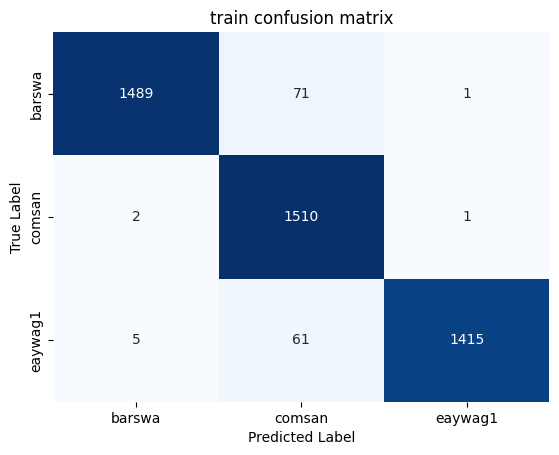

In [ ]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)


# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

## inference on test data

In [ ]:
# predict using the test set
test_yhat = model.predict({
                            'Location': test_features['continent'],
                            'Features': testing_features
                          })
test_yhat_result = np.argmax(test_yhat, axis=-1)

107/107 [==============================] - 2s 17ms/step


In [ ]:
# show the evaluation results
model.evaluate(x={
                  'Location': test_features['continent'],
                  'Features': testing_features
              },
              y=test_y)

107/107 [==============================] - 2s 17ms/step - loss: 0.4166 - accuracy: 0.8943 - weighted_accuracy: 0.8943


[0.41658174991607666, 0.8942731022834778, 0.8942731022834778]

In [ ]:
# show the classification report
print('\nTest Classification Report\n')
print(classification_report(test_y, test_yhat_result, target_names=classes))


Test Classification Report

              precision    recall  f1-score   support

      barswa       0.93      0.88      0.91      1288
      comsan       0.84      0.96      0.89      1063
     eaywag1       0.93      0.84      0.88      1054

    accuracy                           0.89      3405
   macro avg       0.90      0.89      0.89      3405
weighted avg       0.90      0.89      0.89      3405



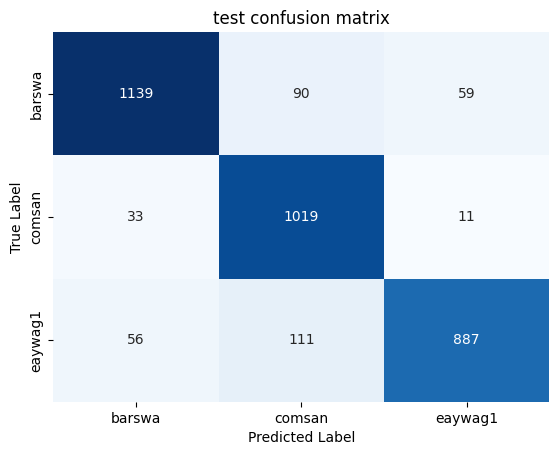

In [ ]:
# calculate the confusion matrix
test_cm = tf.math.confusion_matrix(test_y, test_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(test_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('test confusion matrix')
plt.show()